# Semi-Supervised Learning

**Goal:** Is to develop a machine learning approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle
import os
import json
import contractions
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, RFE
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

/home/daniel/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/daniel/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# Exploratory Data Analysis & Preprocessing

In [2]:
DATAPATH = '/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/dataset/hate_speech'
trainSet = pd.read_csv(os.path.join(DATAPATH, 'train.csv'))
testSet = pd.read_csv(os.path.join(DATAPATH, 'test.csv'))
# Remove all records with no label
trainSet = trainSet[trainSet.label != '']

print(trainSet.shape)
print(testSet.shape)
trainSet.info()
# Load the custom stopwords
with open('stopWords/stopwords_json.json', 'r') as f:
    stopwords_json = json.load(f)
    f.close()

(31962, 3)
(17197, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


In [3]:
trainSet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
testSet.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


# Target Exploration (label)

In [5]:
trainSet.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

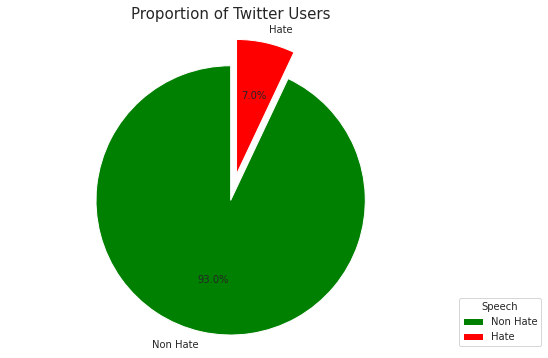

In [6]:
size=trainSet.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 7% of twitter users might `Hate`. So the baseline model could be to predict that 7% of the users will Hate. Given 7% is a small number, we need to ensure that the chosen model does predict with great accuracy this 7% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [7]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1), max_features=800, use_idf=True)
lemmatizer = WordNetLemmatizer()
stopwords_json = set(stopwords_json)
stopwords = set(stopwords.words('english'))
# Remove stopwords to capture negativity in n-grams
stopwords.remove('no')
stopwords.remove('not')
stopwords.remove('but')
stopwords_json.remove('no')
stopwords_json.remove('not')
stopwords_json.remove('but')
# Combine the punctuation with both stopwords
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)



def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace('ii', '').replace('iii', '')
    final_sent = final_sent.replace("'s", "").replace("''", "").replace("nt", "not")
    return final_sent

trainSet['cleaned_tweet'] = trainSet.tweet.apply(preprocess_text)
testSet['cleaned_tweet'] = testSet.tweet.apply(preprocess_text)

trainSet

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dy...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user lyft credit ca not not offer whee...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love time you are
4,5,0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate user isz youuu
31958,31959,0,to see nina turner on the airwaves trying to...,nina turner airwave wrap manotle genuine hero ...
31959,31960,0,listening to sad songs on a monday morning otw...,listen sad song monday morning otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",user sikh temple vandalise calgary wso c...


In [8]:
trainSet.tweet[31957]

'ate @user isz that youuu?ð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dâ\x9d¤ï¸\x8f '

In [9]:
trainSet.cleaned_tweet[31957]

'ate  user isz youuu  '

In [10]:
testSet

,id,tweet,cleaned_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife require passion dedica...
1,31964,@user #white #supremacists want everyone to s...,user white supremacist birds movie
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe heal acne altwaystoheal healthy heal
3,31966,is the hp and the cursed child book up for res...,hp cursed child book reservation no har...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",bihday amazing hilarious nephew eli ahmir ...
...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factory leftright polarisation trum...
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feel mermaid hairflip neverready formal w...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,hillary campaign today ohio omg amp w...
17195,49158,"happy, at work conference: right mindset leads...",happy work conference mindset lead cultureof...


In [11]:
print(f'The longest for train tweet is: {max(trainSet.cleaned_tweet.str.len())}')
print(f'The shortest for train tweet is: {min(trainSet.cleaned_tweet.str.len())}')
print(f'The longest for train tweet is: {max(testSet.cleaned_tweet.str.len())}')
print(f'The shortest for train tweet is: {min(testSet.cleaned_tweet.str.len())}')

The longest for train tweet is: 196
The shortest for train tweet is: 0
The longest for train tweet is: 130
The shortest for train tweet is: 0


# Visualize the frequency of Words

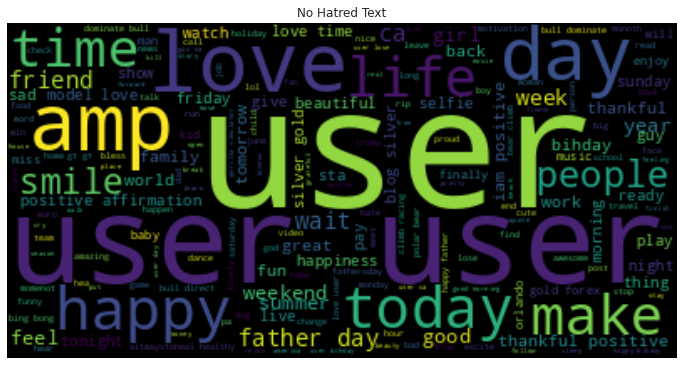

In [12]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = trainSet[trainSet['label']==0]
hate = trainSet[trainSet['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_tweet))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('No Hatred Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` statements**

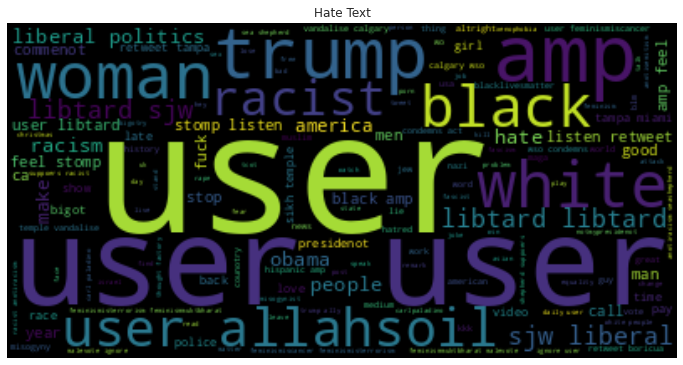

In [13]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_tweet))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

**While these are `hate` statements**

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [14]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

trainSet['noun_count'] = trainSet.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
trainSet['verb_count'] = trainSet.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
trainSet['adj_count'] = trainSet.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
trainSet['adv_count'] = trainSet.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
trainSet['pron_count'] = trainSet.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

testSet['noun_count'] = testSet.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
testSet['verb_count'] = testSet.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
testSet['adj_count'] = testSet.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
testSet['adv_count'] = testSet.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
testSet['pron_count'] = testSet.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

CPU times: user 5min 9s, sys: 2.47 s, total: 5min 11s
Wall time: 5min 11s


In [15]:
trainSet['char_count'] = trainSet.tweet.apply(len)
trainSet['word_count'] = trainSet.tweet.apply(lambda x: len(x.split()))
trainSet['uniq_word_count'] = trainSet.tweet.apply(lambda x: len(set(x.split())))
trainSet['htag_count'] = trainSet.tweet.apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
trainSet['stopword_count'] = trainSet.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
trainSet['sent_count'] = trainSet.tweet.apply(lambda x: len(sent_tokenize(x)))
trainSet['avg_word_len'] = trainSet['char_count']/(trainSet['word_count']+1)
trainSet['avg_sent_len'] = trainSet['word_count']/(trainSet['sent_count']+1)
trainSet['uniq_vs_words'] = trainSet.uniq_word_count/trainSet.word_count # Ratio of unique words to the total number of words
trainSet['stopwords_vs_words'] = trainSet.stopword_count/trainSet.word_count
trainSet['title_word_count'] = trainSet.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainSet['uppercase_count'] = trainSet.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
trainSet.drop(['id', 'tweet'], axis=1, inplace=True)

testSet['char_count'] = testSet.tweet.apply(len)
testSet['word_count'] = testSet.tweet.apply(lambda x: len(x.split()))
testSet['uniq_word_count'] = testSet.tweet.apply(lambda x: len(set(x.split())))
testSet['htag_count'] = testSet.tweet.apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
testSet['stopword_count'] = testSet.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
testSet['sent_count'] = testSet.tweet.apply(lambda x: len(sent_tokenize(x)))
testSet['avg_word_len'] = testSet['char_count']/(testSet['word_count']+1)
testSet['avg_sent_len'] = testSet['word_count']/(testSet['sent_count']+1)
testSet['uniq_vs_words'] = testSet.uniq_word_count/testSet.word_count
testSet['stopwords_vs_words'] = testSet.stopword_count/testSet.word_count
testSet['title_word_count'] = testSet.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
testSet['uppercase_count'] = testSet.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
testSet.drop(['id', 'tweet'], axis=1, inplace=True)

# Get train labels and remove it from the training set
trainLabel = trainSet.label
trainSet.drop('label', axis=1, inplace=True)

## Encoding Text

In [16]:
# We will encode text data using TF-IDF
tfVectorizer.fit(trainSet.cleaned_tweet)
train_tfidf_feats = tfVectorizer.transform(trainSet.cleaned_tweet).toarray()
test_tfidf_feats = tfVectorizer.transform(testSet.cleaned_tweet).toarray()
train_tfidf = pd.DataFrame(train_tfidf_feats, columns=tfVectorizer.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf_feats, columns=tfVectorizer.get_feature_names())
# Join both DataFrames
train = train_tfidf.merge(trainSet, left_index=True, right_index=True)
test = test_tfidf.merge(testSet, left_index=True, right_index=True)
train = train.drop(['cleaned_tweet'], axis=1)
test = test.drop(['cleaned_tweet'], axis=1)

In [17]:
train.head()

,absolutely,accept,accounot,act,action,actor,adapt,add,advenoture,affirmation,afternoon,age,ago,agree,ahead,ai,album,all,allahsoil,altwaystoheal,am,amaze,amazing,america,american,amp,angry,animal,anniversary,announce,answer,anxiety,anymore,app,apple,are,arrive,asian,attack,award,awesome,aww,baby,back,bad,bag,beach,bear,beat,beautiful,beauty,bed,beer,begin,big,bihday,bike,bing,bird,birthday,bit,bitch,black,blame,bless,block,blog,blogger,blonde,blue,blur,body,bong,book,boy,boyfriend,brand,break,breakfast,brexit,bring,broken,brother,buffalo,bull,business,busy,but,buy,ca,cake,call,camp,campaign,canotwait,car,card,care,case,cat,catch,celebrate,celebration,chance,change,chase,check,cheer,child,chill,choice,choose,church,city,class,clean,clienot,climb,close,club,coffee,cold,college,color,commenot,community,company,complete,conce,conference,congrats,congratulation,conotenot,conotinue,conotrol,cool,counot,counotdown,counotry,couple,cover,crazy,create,cry,cultureofdevelopmenot,customer,cut,cute,da,dad,daddy,daily,damn,dance,dark,date,daughter,day,dead,deal,dear,death,decide,deep,delete,deletetweets,depressed,depression,deserve,design,die,dinner,direct,disappoinoted,disney,dj,do,dog,dominate,donald,draw,dream,dress,drink,drive,drop,due,early,easy,eat,education,emotion,empty,end,energy,england,enjoy,environmenot,episode,euro,evening,evenot,everyday,excite,excited,expanse,expect,experience,eye,face,facebook,fact,fail,faith,fall,family,fan,fanotastic,fashion,fast,father,fathersday,favorite,fear,feel,feeling,female,festival,ff,fight,fill,film,final,finally,find,finger,finish,fire,fit,fitness,flag,flight,florida,flower,fly,folk,follow,follower,followme,food,football,forever,forex,forget,forward,france,free,freedom,fresh,friday,fridayfeeling,friend,friendship,fuck,full,fun,funny,future,game,garden,gay,gbp,germany,gift,girl,give,glad,glass,goal,god,gold,gon,good,goodmorning,gop,gorgeous,gorilla,grateful,great,green,group,grow,gt,guess,gun,guy,gym,haha,hair,half,hand,happen,happiness,happy,hard,hardcore,hat,hate,hatred,hea,heabroken,head,heal,health,healthy,hear,hell,hero,hey,high,hill,hillary,history,hit,hold,holiday,home,hope,horny,hot,hour,house,hr,ht,htt,hu,hug,huge,human,hungry,husband,iam,idea,idiot,ignore,impoanot,india,inoternet,inshot,inside,inspiration,inspire,instadaily,instagood,instagram,instalike,instamood,is,islam,issue,japan,job,join,joke,joy,july,june,key,kick,kid,kill,kind,king,kinky,kiss,la,lady,late,laugh,launch,law,lawofattraction,lead,leader,leadership,learn,leave,lgbt,liberal,libtard,lie,life,lifestyle,light,lighttherapy,likelike,line,link,list,listen,literally,live,living,local,lol,london,lonely,long,lose,loss,lot,love,lovely,lover,low,lt,luck,lucky,lunch,mad,make,makeup,man,mass,matter,medium,meet,meeting,member,memory,men,message,miami,mind,mindset,mine,minute,miss,model,mom,momenot,monday,money,monoth,mood,morning,mother,motivation,mounotain,move,movie,mr,murder,music,muslim,na,nail,naked,nasty,nation,national,nature,naughty,nbafinals,nervous,news,newyork,nice,nigga,night,no,not,notice,nude,number,nyc,obama,offer,office,official,officially,oil,oitnb,omg,online,open,order,organization,orlando,orlandoshooting,pa,pack,page,pain,parenot,paris,park,pass,past,pathetic,pay,peace,people,perfect,person,pet,phone,photo,photography,photooftheday,pic,pick,picoftheday,picture,pink,pizza,place,plan,play,pm,poetry,poinot,polar,police,political,politics,pool,poor,pop,porn,positive,post,power,pray,prayer,prayfororlando,presenot,presidenot,pretty,previous,pride,problem,product,project,proud,punjab,puppy,pussy,put,queen,question,quote,race,racing,racism,racist,rain,ramadan,reach,read,ready,real,reality,realize,reason,receive,record,red,relationship,relax,release,remember,republican,respect,rest,result,return,retweet,review,ride,rip,ripchristina,road,rock,room,rooster,run,sad,safe,sale,saturday,save,school,sea,season,secret,selfie,sell,send,sense,series,service,session,set,sex,sexy,shame,share,shit,sho,shock,shoe,shoot,shooting,shop,shopp

In [18]:
test.head()

,absolutely,accept,accounot,act,action,actor,adapt,add,advenoture,affirmation,afternoon,age,ago,agree,ahead,ai,album,all,allahsoil,altwaystoheal,am,amaze,amazing,america,american,amp,angry,animal,anniversary,announce,answer,anxiety,anymore,app,apple,are,arrive,asian,attack,award,awesome,aww,baby,back,bad,bag,beach,bear,beat,beautiful,beauty,bed,beer,begin,big,bihday,bike,bing,bird,birthday,bit,bitch,black,blame,bless,block,blog,blogger,blonde,blue,blur,body,bong,book,boy,boyfriend,brand,break,breakfast,brexit,bring,broken,brother,buffalo,bull,business,busy,but,buy,ca,cake,call,camp,campaign,canotwait,car,card,care,case,cat,catch,celebrate,celebration,chance,change,chase,check,cheer,child,chill,choice,choose,church,city,class,clean,clienot,climb,close,club,coffee,cold,college,color,commenot,community,company,complete,conce,conference,congrats,congratulation,conotenot,conotinue,conotrol,cool,counot,counotdown,counotry,couple,cover,crazy,create,cry,cultureofdevelopmenot,customer,cut,cute,da,dad,daddy,daily,damn,dance,dark,date,daughter,day,dead,deal,dear,death,decide,deep,delete,deletetweets,depressed,depression,deserve,design,die,dinner,direct,disappoinoted,disney,dj,do,dog,dominate,donald,draw,dream,dress,drink,drive,drop,due,early,easy,eat,education,emotion,empty,end,energy,england,enjoy,environmenot,episode,euro,evening,evenot,everyday,excite,excited,expanse,expect,experience,eye,face,facebook,fact,fail,faith,fall,family,fan,fanotastic,fashion,fast,father,fathersday,favorite,fear,feel,feeling,female,festival,ff,fight,fill,film,final,finally,find,finger,finish,fire,fit,fitness,flag,flight,florida,flower,fly,folk,follow,follower,followme,food,football,forever,forex,forget,forward,france,free,freedom,fresh,friday,fridayfeeling,friend,friendship,fuck,full,fun,funny,future,game,garden,gay,gbp,germany,gift,girl,give,glad,glass,goal,god,gold,gon,good,goodmorning,gop,gorgeous,gorilla,grateful,great,green,group,grow,gt,guess,gun,guy,gym,haha,hair,half,hand,happen,happiness,happy,hard,hardcore,hat,hate,hatred,hea,heabroken,head,heal,health,healthy,hear,hell,hero,hey,high,hill,hillary,history,hit,hold,holiday,home,hope,horny,hot,hour,house,hr,ht,htt,hu,hug,huge,human,hungry,husband,iam,idea,idiot,ignore,impoanot,india,inoternet,inshot,inside,inspiration,inspire,instadaily,instagood,instagram,instalike,instamood,is,islam,issue,japan,job,join,joke,joy,july,june,key,kick,kid,kill,kind,king,kinky,kiss,la,lady,late,laugh,launch,law,lawofattraction,lead,leader,leadership,learn,leave,lgbt,liberal,libtard,lie,life,lifestyle,light,lighttherapy,likelike,line,link,list,listen,literally,live,living,local,lol,london,lonely,long,lose,loss,lot,love,lovely,lover,low,lt,luck,lucky,lunch,mad,make,makeup,man,mass,matter,medium,meet,meeting,member,memory,men,message,miami,mind,mindset,mine,minute,miss,model,mom,momenot,monday,money,monoth,mood,morning,mother,motivation,mounotain,move,movie,mr,murder,music,muslim,na,nail,naked,nasty,nation,national,nature,naughty,nbafinals,nervous,news,newyork,nice,nigga,night,no,not,notice,nude,number,nyc,obama,offer,office,official,officially,oil,oitnb,omg,online,open,order,organization,orlando,orlandoshooting,pa,pack,page,pain,parenot,paris,park,pass,past,pathetic,pay,peace,people,perfect,person,pet,phone,photo,photography,photooftheday,pic,pick,picoftheday,picture,pink,pizza,place,plan,play,pm,poetry,poinot,polar,police,political,politics,pool,poor,pop,porn,positive,post,power,pray,prayer,prayfororlando,presenot,presidenot,pretty,previous,pride,problem,product,project,proud,punjab,puppy,pussy,put,queen,question,quote,race,racing,racism,racist,rain,ramadan,reach,read,ready,real,reality,realize,reason,receive,record,red,relationship,relax,release,remember,republican,respect,rest,result,return,retweet,review,ride,rip,ripchristina,road,rock,room,rooster,run,sad,safe,sale,saturday,save,school,sea,season,secret,selfie,sell,send,sense,series,service,session,set,sex,sexy,shame,share,shit,sho,shock,shoe,shoot,shooting,shop,shopp

# Check for Missing Values

In [19]:
print(train.isnull().sum().sort_values(ascending=False))

absolutely         0
queen              0
previous           0
pride              0
problem            0
                  ..
give               0
glad               0
glass              0
goal               0
uppercase_count    0
Length: 817, dtype: int64


In [20]:
print(test.isnull().sum().sort_values(ascending=False))

absolutely         0
queen              0
previous           0
pride              0
problem            0
                  ..
give               0
glad               0
glass              0
goal               0
uppercase_count    0
Length: 817, dtype: int64


# Scale & Split the Dataset

In [21]:
scaler = StandardScaler()
scaler.fit(train)
scaled = scaler.transform(train)

X_train, X_test, y_train, y_test = train_test_split(scaled, trainLabel, stratify = trainLabel, test_size = 0.2, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25569, 817) (6393, 817) (25569,) (6393,)


# Model Building & Evaluation

In [22]:
# nb_clf = MultinomialNB()
# nb_clf.fit(X_train, y_train)
# pred = nb_clf.predict_proba(X_test)[:, 1]
# y_pred = nb_clf.predict(X_test)
# print(f"ROC AUC Naive Bayes Score: {roc_auc_score(y_test, pred):.4f}")
# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# plt.show()

## Logistic Regression & Parameter tuning

In [23]:
def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'], yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    logReg = LogisticRegression(solver='liblinear', C=c)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

0.0001->0.8938
0.001->0.8989
0.01->0.9043
0.1->0.9052
1->0.9005
10->0.8957


In [24]:
for m in [0.01, 0.1, 1]:
    print(f"Inverse of regularization strength {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        logReg = LogisticRegression(solver='liblinear', C=m, tol=tol)
        logReg.fit(X_train, y_train)
        pred = logReg.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength 0.01
1e-05->0.9043
0.0001->0.9043
0.001->0.9043
0.01->0.9043
0.1->0.9037
1->0.9007
10->0.8868

Inverse of regularization strength 0.1
1e-05->0.9052
0.0001->0.9052
0.001->0.9052
0.01->0.9052
0.1->0.9053
1->0.9020
10->0.8866

Inverse of regularization strength 1
1e-05->0.9005
0.0001->0.9005
0.001->0.9005
0.01->0.9016
0.1->0.9049
1->0.9020
10->0.8866



In [25]:
for maxIt in [1, 5, 10, 15, 20]:
    logReg = LogisticRegression(solver='liblinear', C=0.1, tol=0.1, max_iter=maxIt)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{maxIt}->{auc:.4f}")

1->0.8866
5->0.9053
10->0.9053
15->0.9053
20->0.9053


In [26]:
for mClass in ["auto", "ovr"]:
    logReg = LogisticRegression(solver='liblinear', C=0.1, tol=0.1, max_iter=5, multi_class=mClass)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9053
ovr->0.9053


ROC AUC Logistic Regression Score: 0.9053


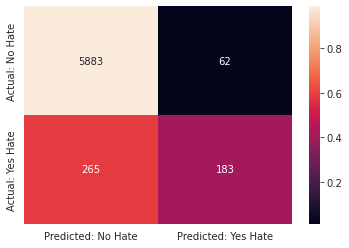

In [27]:
logReg = LogisticRegression(solver='liblinear',
                            C=0.1, tol=0.1, max_iter=5, 
                            multi_class='auto')

logReg.fit(X_train, y_train)
pred = logReg.predict_proba(X_test)[:, 1]
y_pred = logReg.predict(X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

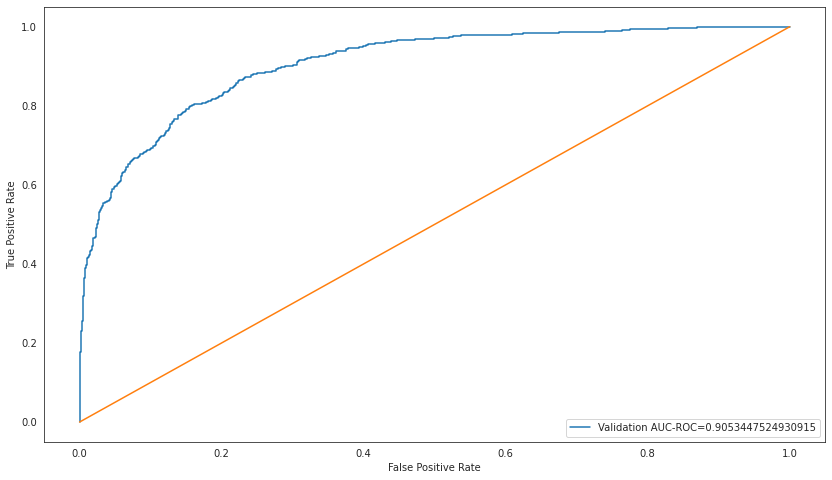

In [28]:
plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Random Forest & Parameter tuning

In [29]:
for n in [150, 200, 250, 300, 350]:
    rFc = RandomForestClassifier(n_estimators=n, random_state=42)
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

150->0.9020
200->0.9034
250->0.9033
300->0.9051
350->0.9063


In [30]:
del m
del tol
for m in [250, 300, 350]:
    print(f"Number of estimators {m}")
    
    for c in ["gini", "entropy"]:
        rFc = RandomForestClassifier(n_estimators=m, criterion=c, random_state=42)
        rFc.fit(X_train, y_train)
        pred = rFc.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Number of estimators 250
gini->0.9033
entropy->0.9060

Number of estimators 300
gini->0.9051
entropy->0.9087

Number of estimators 350
gini->0.9063
entropy->0.9088



In [31]:
for depth in [5, 10, 15, None]:
    rFc = RandomForestClassifier(n_estimators=350, criterion='entropy', max_depth=depth, random_state=42)
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{depth}->{auc:.4f}")

5->0.8570
10->0.8778
15->0.8885
None->0.9088


In [32]:
for samp in [0.01, 0.1, 0.5, 2]:
    rFc = RandomForestClassifier(
        n_estimators=350,
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=samp,
        random_state=42
    )
    
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

0.01->0.9069
0.1->0.8925
0.5->0.8492
2->0.9088


In [33]:
for leaf in [0.01, 0.1, 0.5, 2]:
    rFc = RandomForestClassifier(
        n_estimators=350,
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=leaf,
        random_state=42
    )
    
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{leaf}->{auc:.4f}")

0.01->0.7181
0.1->0.6324
0.5->0.5000
2->0.9109


ROC AUC Random Forest Classifier Score: 0.9088


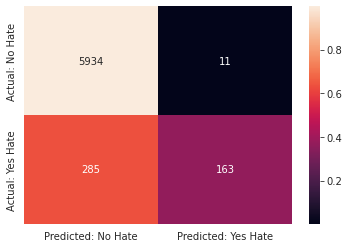

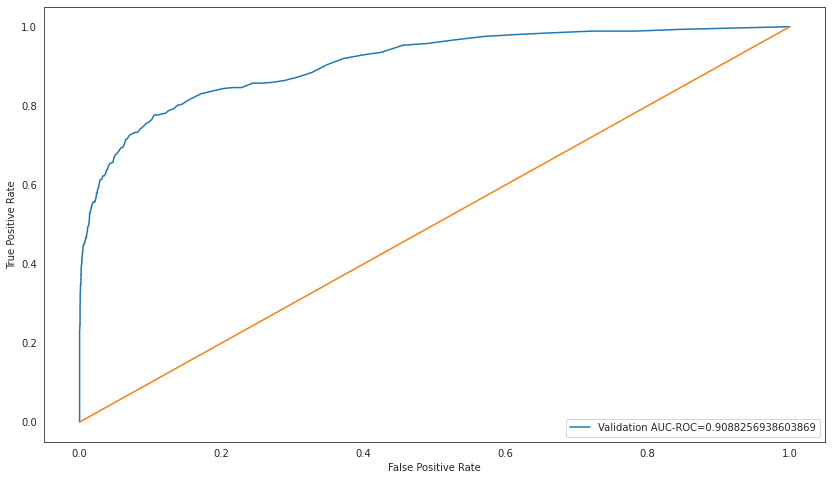

In [34]:
rFc = RandomForestClassifier(n_estimators=350, criterion='entropy', max_depth=None, 
                             min_samples_split=2, random_state=42)
rFc.fit(X_train, y_train)
pred = rFc.predict_proba(X_test)[:, 1]
y_pred = rFc.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [35]:
cols_todisplay = 80
importance_feat = rFc.feature_importances_
sorted_idx = np.argsort(importance_feat)[::-1]

print('These are the most importance Features\n')
for i in range(X_train.shape[1]):
    print(f"{i + 1,cols_todisplay} {train.columns[sorted_idx[i]]} ----> {importance_feat[sorted_idx[i]]:.12f}\n")

These are the most importance Features

(1, 80) avg_word_len ----> 0.038045469831

(2, 80) char_count ----> 0.037778144113

(3, 80) user ----> 0.035243754709

(4, 80) stopwords_vs_words ----> 0.027874411774

(5, 80) avg_sent_len ----> 0.025859991175

(6, 80) noun_count ----> 0.023701548396

(7, 80) allahsoil ----> 0.023535457360

(8, 80) trump ----> 0.022803395458

(9, 80) uniq_word_count ----> 0.022710651410

(10, 80) white ----> 0.022525371861

(11, 80) word_count ----> 0.021968537463

(12, 80) stopword_count ----> 0.021039062940

(13, 80) adj_count ----> 0.019424183079

(14, 80) verb_count ----> 0.019316465488

(15, 80) uniq_vs_words ----> 0.017928034834

(16, 80) racist ----> 0.015807885544

(17, 80) adv_count ----> 0.015461997685

(18, 80) amp ----> 0.013862884535

(19, 80) pron_count ----> 0.013508641192

(20, 80) black ----> 0.013343715995

(21, 80) woman ----> 0.012699515201

(22, 80) racism ----> 0.012651385498

(23, 80) sent_count ----> 0.011423813758

(24, 80) not ----> 0.01

In [36]:
rFc_best_feats = train[train.columns[sorted_idx[:80]]]
rFc_best_feats.head()

,avg_word_len,char_count,user,stopwords_vs_words,avg_sent_len,noun_count,allahsoil,trump,uniq_word_count,white,word_count,stopword_count,adj_count,verb_count,uniq_vs_words,racist,adv_count,amp,pron_count,black,woman,racism,sent_count,not,day,love,obama,commenot,politics,libtard,sjw,act,liberal,hate,call,stomp,men,happy,hatred,late,ignore,fuck,htag_count,retweet,video,stop,race,america,no,listen,but,muslim,people,are,today,life,year,daily,police,good,presidenot,brexit,history,naked,word,girl,make,time,positive,miami,world,american,japan,man,speak,great,counotry,sex,suppoers,show
0,5.368421,102,0.206703,0.555556,6.000000,5,0.0,0.0,16,0.0,18,10,2,4,0.888889,0.0,2,0.0,3,0.0,0.0,0.0,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.100000,122,0.348672,0.263158,6.333333,8,0.0,0.0,18,0.0,19,5,3,5,0.947368,0.0,2,0.0,1,0.0,0.0,0.0,2,0.551185,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.250000,21,0.000000,0.333333,1.500000,1,0.0,0.0,3,0.0,3,1,0,0,1.000000,0.0,1,0.0,1,0.0,0.0,0.0,1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.733333,86,0.000000,0.357143,4.666667,5,0.0,0.0,13,0.0,14,5,1,2,0.928571,0.0,0,0.0,2,0.0,0.0,0.0,2,0.000000,0.0,0.332001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.435432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.800000,39,0.000000,0.250000,2.000000,3,0.0,0.0,4,0.0,4,1,0,0,1.000000,0.0,1,0.0,0,0.0,0.0,0.0,1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC AUC Random Forest Classifier Score after Feature Selection: 0.8894


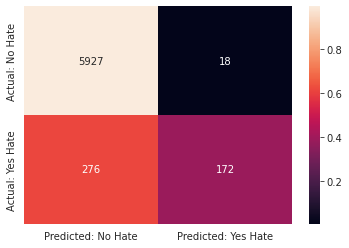

In [37]:
rFc_scaler = StandardScaler()
rFc_scaler.fit(rFc_best_feats)
rFc_scaled = rFc_scaler.transform(rFc_best_feats)

X_train_rFc, X_test_rFc, y_train_rFc, y_test_rFc = train_test_split(rFc_scaled, trainLabel, stratify = trainLabel, test_size = 0.2, random_state = 42)

rFc = RandomForestClassifier(n_estimators=350, criterion='entropy', max_depth=None, min_samples_split=2)
rFc.fit(X_train_rFc, y_train_rFc)
pred = rFc.predict_proba(X_test_rFc)[:, 1]
y_pred = rFc.predict(X_test_rFc)
print(f"ROC AUC Random Forest Classifier Score after Feature Selection: {roc_auc_score(y_test_rFc, pred):.4f}")
cm = confusion_matrix(y_test_rFc, y_pred)
confusion_matrix_plot(cm)
plt.show()

**The previous Random Forest Model performed better than after Feature Selection**

## Decision Tree & Parameter tuning

In [38]:
del depth
for depth in [5, 10, 15, 20, 25]:
    dTc = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dTc.fit(X_train, y_train)
    pred = dTc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{depth}->{auc:.4f}")

5->0.6239
10->0.7287
15->0.7246
20->0.7134
25->0.7049


In [39]:
del m
del c
for m in [10, 15, 20]:
    print(f"Maximum Depth {m}")
    
    for c in ["gini", "entropy"]:
        dTc = DecisionTreeClassifier(random_state=42, max_depth=m, criterion=c)
        dTc.fit(X_train, y_train)
        pred = dTc.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Maximum Depth 10
gini->0.7287
entropy->0.7570

Maximum Depth 15
gini->0.7246
entropy->0.7563

Maximum Depth 20
gini->0.7134
entropy->0.7472



In [40]:
for samp in [0.01, 0.1, 0.5, 2]:
    dTc = DecisionTreeClassifier(random_state=42, max_depth=10, criterion='entropy', 
                                 min_samples_split=samp)
    
    dTc.fit(X_train, y_train)
    pred = dTc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

0.01->0.7678
0.1->0.7678
0.5->0.7571
2->0.7570


ROC AUC Decision Tree Classifier Score: 0.7678


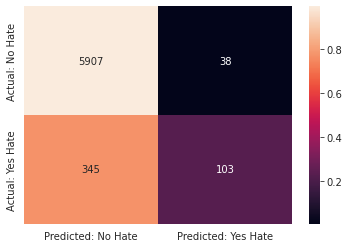

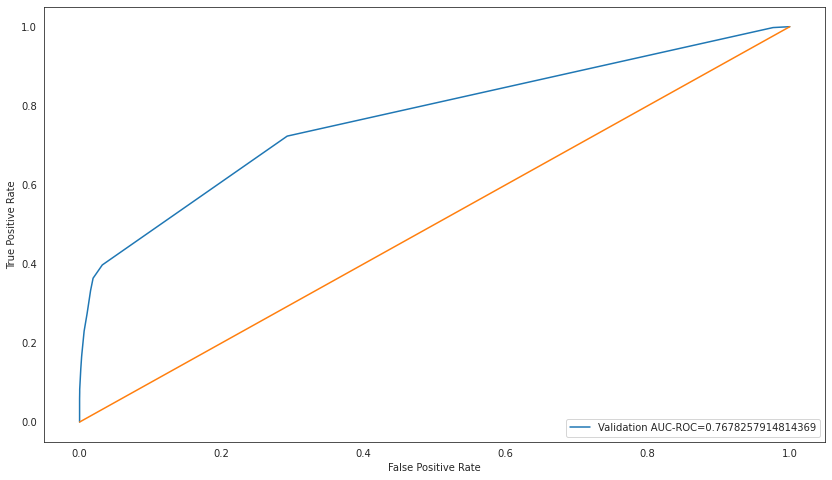

In [41]:
dTc = DecisionTreeClassifier(random_state=42, max_depth=10, criterion='entropy', 
                             min_samples_split=0.01)

dTc.fit(X_train, y_train)
pred = dTc.predict_proba(X_test)[:, 1]
y_pred = dTc.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Decision Tree Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## XGBoost & Parameter tuning

In [30]:
for n in [50, 100, 250, 300]:
    xgb_model = XGBClassifier(n_estimators=n, eval_metric="auc", 
                              objective='binary:logistic')
    
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

50->0.9071
100->0.9176
150->0.9230
200->0.9265
250->0.9273
300->0.9274


In [32]:
for lr in [0.1, 1, 1.5]:
    xgb_model = XGBClassifier(n_estimators=300, eval_metric="auc", 
                              objective='binary:logistic', learning_rate=lr)
    
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

1e-06->0.6316
1e-05->0.6316
0.0001->0.6436
0.001->0.6620
0.01->0.8515
0.1->0.9225
1->0.8964
1.5->0.8486


ROC AUC XGBoost Classifier Score: 0.9274


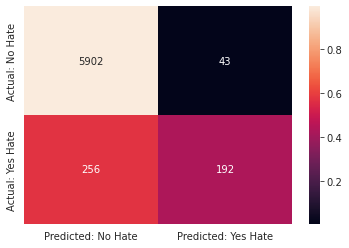

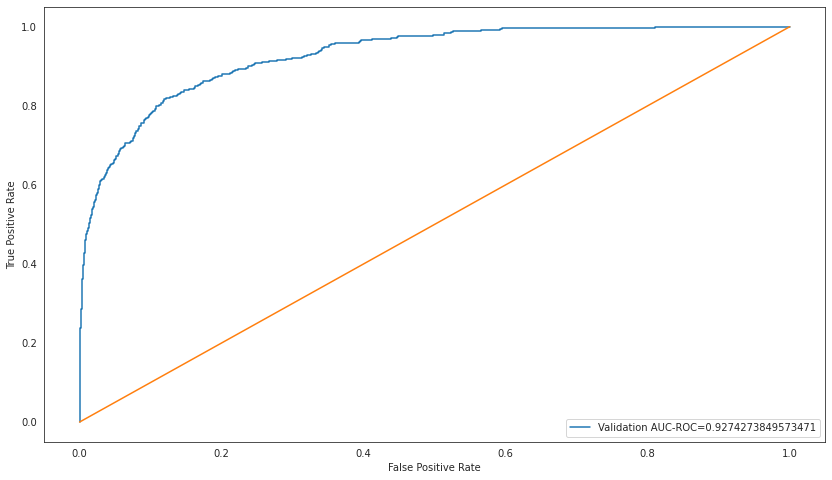

,label,Predicted_class
436,0,0
27813,0,0
15446,0,0
3036,0,0
420,0,0
16040,0,0
5042,0,0
14899,0,0
25050,0,0
17456,0,0


In [42]:
xgb_model = XGBClassifier(n_estimators=300, eval_metric="auc", 
                          objective='binary:logistic')

xgb_model.fit(X_train, y_train)
pred = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

The XGBoost model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [43]:
def cross_validation_score(ml_model, thres = 0.5, random_st=42, cols = train.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = train.copy()
    x1 = train[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xval)
        pred_probs = model.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Logistic Regression

In [44]:
y=trainLabel
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear',
                                                         C=0.1, tol=0.1, max_iter=5, 
                                                         multi_class='auto')
                                     )


1 of KFold 5
ROC AUC Score: 0.4360, Recall Score: 0.0000, Precision Score: 0.0000

2 of KFold 5
ROC AUC Score: 0.4414, Recall Score: 0.0000, Precision Score: 0.0000

3 of KFold 5
ROC AUC Score: 0.4327, Recall Score: 0.0000, Precision Score: 0.0000

4 of KFold 5
ROC AUC Score: 0.4360, Recall Score: 0.0000, Precision Score: 0.0000

5 of KFold 5
ROC AUC Score: 0.4382, Recall Score: 0.0000, Precision Score: 0.0000


## MultinomialNB

In [45]:
nb_cv_score = cross_validation_score(MultinomialNB())


1 of KFold 5
ROC AUC Score: 0.9031, Recall Score: 0.2339, Precision Score: 0.7500

2 of KFold 5
ROC AUC Score: 0.9051, Recall Score: 0.2517, Precision Score: 0.8188

3 of KFold 5
ROC AUC Score: 0.9057, Recall Score: 0.2500, Precision Score: 0.7517

4 of KFold 5
ROC AUC Score: 0.9025, Recall Score: 0.2946, Precision Score: 0.7811

5 of KFold 5
ROC AUC Score: 0.9017, Recall Score: 0.2812, Precision Score: 0.7412


## RandomForestClassifier

In [46]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=350, criterion='entropy', max_depth=None, 
                                                            min_samples_split=2, random_state=42)
                                    )


1 of KFold 5
ROC AUC Score: 0.9085, Recall Score: 0.3408, Precision Score: 0.9273

2 of KFold 5
ROC AUC Score: 0.9196, Recall Score: 0.3229, Precision Score: 0.9477

3 of KFold 5
ROC AUC Score: 0.9145, Recall Score: 0.3571, Precision Score: 0.9195

4 of KFold 5
ROC AUC Score: 0.9252, Recall Score: 0.3795, Precision Score: 0.8947

5 of KFold 5
ROC AUC Score: 0.9093, Recall Score: 0.3772, Precision Score: 0.9286


## DecisionTreeClassifier

In [47]:
dt_cv_score = cross_validation_score(DecisionTreeClassifier(random_state=42, max_depth=10, criterion='entropy', 
                                                            min_samples_split=0.01)
                                    )


1 of KFold 5
ROC AUC Score: 0.7527, Recall Score: 0.2606, Precision Score: 0.6802

2 of KFold 5
ROC AUC Score: 0.7793, Recall Score: 0.2249, Precision Score: 0.7652

3 of KFold 5
ROC AUC Score: 0.7513, Recall Score: 0.2143, Precision Score: 0.6957

4 of KFold 5
ROC AUC Score: 0.7541, Recall Score: 0.3304, Precision Score: 0.7150

5 of KFold 5
ROC AUC Score: 0.7745, Recall Score: 0.2478, Precision Score: 0.7208


## XGBClassifier

In [48]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=300, eval_metric="auc", 
                                                    objective='binary:logistic')
                                     )


1 of KFold 5
ROC AUC Score: 0.9127, Recall Score: 0.4120, Precision Score: 0.7872

2 of KFold 5
ROC AUC Score: 0.9282, Recall Score: 0.3831, Precision Score: 0.8000

3 of KFold 5
ROC AUC Score: 0.9159, Recall Score: 0.4152, Precision Score: 0.7686

4 of KFold 5
ROC AUC Score: 0.9214, Recall Score: 0.4442, Precision Score: 0.7713

5 of KFold 5
ROC AUC Score: 0.9152, Recall Score: 0.4554, Precision Score: 0.7786


# Comparison of Model Fold wise

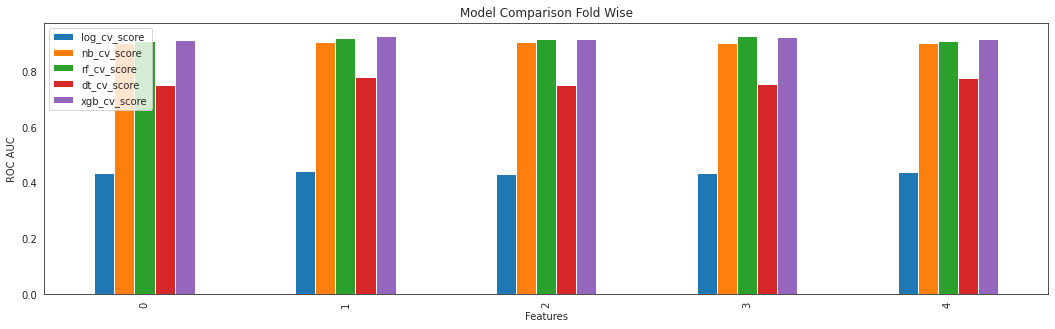

In [49]:
compare_score = pd.DataFrame({'log_cv_score':log_cv_score,
                              'nb_cv_score':nb_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'dt_cv_score':dt_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['log_cv_score', 'nb_cv_score','rf_cv_score',
                        'dt_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `XGBoost Model` has the best performance across 5-fold. Therefore, we will work on improving this model**

In [50]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=300, eval_metric="auc", 
                                                    objective='binary:logistic'), 
                                      thres=0.2)


1 of KFold 5
ROC AUC Score: 0.9127, Recall Score: 0.5679, Precision Score: 0.5403

2 of KFold 5
ROC AUC Score: 0.9282, Recall Score: 0.5724, Precision Score: 0.5775

3 of KFold 5
ROC AUC Score: 0.9159, Recall Score: 0.5938, Precision Score: 0.5496

4 of KFold 5
ROC AUC Score: 0.9214, Recall Score: 0.6228, Precision Score: 0.5492

5 of KFold 5
ROC AUC Score: 0.9152, Recall Score: 0.6205, Precision Score: 0.5571


# Addressing Imbalanced Class with SMOTE

In [51]:
print(train.shape)
print(y.shape)

(31962, 817)
(31962,)


In [52]:
print(y.value_counts())
print(y.value_counts(normalize=True)*100)

0    29720
1     2242
Name: label, dtype: int64
0    92.98542
1     7.01458
Name: label, dtype: float64


In [53]:
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(train, y)
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    29720
1    29720
Name: label, dtype: int64
0    50.0
1    50.0
Name: label, dtype: float64


In [54]:
imb_scaler = StandardScaler()
imb_scaler.fit(x_sm)
imb_scaled = scaler.transform(x_sm)
X_train, X_test, y_train, y_test = train_test_split(imb_scaled, y_sm, stratify=y_sm, 
                                                    random_state= 42, test_size= 0.2)

ROC AUC XGBoost Score: 0.9960
Recall score of XGBoost: 0.9660
Precision score of XGBoost: 0.9799
'%' of Misclassified class: 2.6917900403768504


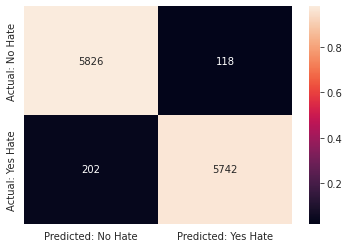

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [55]:
final_model = XGBClassifier(n_estimators=300, eval_metric="auc", 
                            objective='binary:logistic')

final_model.fit(X_train, y_train)
pred = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)
print(f"ROC AUC XGBoost Score: {roc_auc_score(y_test, pred):.4f}")
print(f"Recall score of XGBoost: {recall_score(y_test, y_pred):.4f}")
print(f"Precision score of XGBoost: {precision_score(y_test, y_pred):.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Serialize Tfidf Vectorizer, StandardScaler & the Final Model

In [55]:
with open('vectorizer_label', 'wb') as f:
    pickle.dump(tfVectorizer, f)

with open('data_label_scaler', 'wb') as f:
    pickle.dump(imb_scaler, f)
    
with open('model_labeller', 'wb') as f:
    pickle.dump(final_model, f)